# Tutorial: Running Inference on External Data

This tutorial guides you through running inference on **new/external data** using a pre-trained proT model checkpoint.

## Overview

After training a proT model, you can use it to make predictions on new data that wasn't part of the original training/test split. This is useful for:
- Deploying the model on production data
- Running predictions on newly acquired measurements
- Validating model performance on external datasets

## Prerequisites

Before running this tutorial, ensure you have:

1. **A trained checkpoint** (`.ckpt` file) from a completed training run
2. **The config file** (`.yaml`) used during training
3. **Your new data** in the correct NumPy format (see Data Format section below)

## 1. Setup & Imports

In [1]:
# Standard library imports
import sys
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

# Add project root to path (adjust if needed)
ROOT_PATH = Path("../").resolve()
sys.path.append(str(ROOT_PATH))
sys.path.append(str(ROOT_PATH / "notebooks"))

# proT imports
from proT.evaluation.predict import predict_test_from_ckpt
from notebooks.lib import plot_predictions, plot_attention_heatmap, get_config_and_best_checkpoint_from_experiment

S6 Mamba backend: mamba-pytorch (pure PyTorch fallback)


## 2. Data Format Requirements

Your external data must be prepared in NumPy format with the following specifications:

### Input Data (`X.npy`)
- **Shape**: `(N, L, F_in)` where:
  - `N` = number of samples
  - `L` = sequence length (must match training data)
  - `F_in` = number of input features (must match training data)
- **Dtype**: `float32` recommended
- Missing values should be represented as `NaN`

### Target Data (`Y.npy`)
- **Shape**: `(N, L, F_out)` where:
  - `N` = number of samples (same as input)
  - `L` = sequence length
  - `F_out` = number of target features
- **Dtype**: `float32` recommended

### Directory Structure
```
data/input/
└── your_dataset_name/
    ├── X.npy
    └── Y.npy
```

## 3. Configuration

Set up the paths to your checkpoint, config file, and data directory.

In [7]:
# ============================================================
# CONFIGURE THESE PATHS FOR YOUR USE CASE
# ============================================================


# Path to the data directory containing your external dataset folder
DATA_DIR = ROOT_PATH / "data" / "input"

trained_model_path = "../trained_models/proT_dyconex_sum_200/"

config, CHECKPOINT_PATH = get_config_and_best_checkpoint_from_experiment(trained_model_path)
# Path to the training config file (YAML)
#CONFIG_PATH = "../experiments/baseline_optuna/euler/baseline_proT_dyconex_sum_50908169/optuna/run_43/config.yaml"


# ============================================================
# EXTERNAL DATASET CONFIGURATION
# ============================================================

# Specify your external dataset
# - "dataset": folder name inside DATA_DIR containing your data
# - "filename_input": name of the input file (X.npy or similar)
# - "filename_target": name of the target file (Y.npy or similar)

external_dataset = {
    "dataset": "ds_prediction_tutorial",#"your_dataset_name",  # <-- Replace with your dataset folder name
    "filename_input": "data.npz",
    "filename_target": "data.npz",
}

# Load the model configuration
print("Configuration loaded successfully!")
print(f"Model type: {config.model.model_object}")

Configuration loaded successfully!
Model type: proT


## 4. Running Prediction

Use the `predict_test_from_ckpt()` function with the `external_dataset` parameter to run inference on your new data.

In [8]:
# Run prediction on external dataset
results = predict_test_from_ckpt(
    config=config,
    datadir_path=str(DATA_DIR),
    checkpoint_path=str(CHECKPOINT_PATH),
    external_dataset=external_dataset,
    dataset_label="all",  # Use "all" to predict on the entire external dataset
    cluster=False  # Set to True if running on a compute cluster
)

print(f"\nPrediction complete!")
print(f"Number of samples predicted: {results.metadata['num_samples']}")

Seed set to 42


Dataset in one numpy file.
Input shape:  (16, 986, 12)
Target shape:  (16, 400, 9)
Dataset in one numpy file.
Input shape:  (16, 986, 12)
Target shape:  (16, 400, 9)
All data selected.
Predicting...


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]



Prediction complete!
Number of samples predicted: 16


## 5. Accessing Results

The `predict_test_from_ckpt()` function returns a `PredictionResult` object with the following attributes:

| Attribute | Description | Shape |
|-----------|-------------|-------|
| `results.inputs` | Input data array | `(N, L, F_in)` |
| `results.outputs` | Model predictions | `(N, L)` or `(N, L, F_out)` |
| `results.targets` | Target data | `(N, L, F_out)` |
| `results.attention_weights` | Cross-attention weights (dict) | varies |
| `results.metadata` | Model/run information (dict) | - |

In [9]:
# Access the prediction arrays
input_array = results.inputs
output_array = results.outputs
target_array = results.targets

print(f"Input shape: {input_array.shape}")
print(f"Output (prediction) shape: {output_array.shape}")
print(f"Target shape: {target_array.shape}")

# Check if attention weights are available
if results.attention_weights is not None:
    print(f"\nAttention weights available: {list(results.attention_weights.keys())}")
else:
    print("\nNo attention weights available (baseline model)")

# Print metadata
print(f"\nMetadata: {results.metadata}")

Input shape: (16, 986, 12)
Output (prediction) shape: (16, 400)
Target shape: (16, 400, 9)

Attention weights available: ['encoder', 'decoder', 'cross']

Metadata: {'model_type': 'proT', 'dataset_label': 'all', 'batch_size': 50, 'num_samples': 16}


## 6. Visualization

### 6.1 Prediction vs Target Comparison

In [10]:
results.outputs

array([[-0.0163077 , -0.01803739, -0.01990153, ...,  0.44043514,
         0.44286895,  0.4383908 ],
       [-0.0163077 , -0.01803739, -0.01990153, ...,  0.44043514,
         0.44286895,  0.4383908 ],
       [-0.01633959, -0.01812111, -0.02005523, ...,  0.4469151 ,
         0.44933283,  0.4447284 ],
       ...,
       [-0.01812683, -0.01995581, -0.02204129, ...,  0.4704203 ,
         0.47309452,  0.4677862 ],
       [-0.01865922, -0.02040946, -0.02245604, ...,  0.46372214,
         0.466352  ,  0.4612288 ],
       [-0.01726243, -0.01909024, -0.02119234, ...,  0.47296286,
         0.4757039 ,  0.470301  ]], shape=(16, 400), dtype=float32)

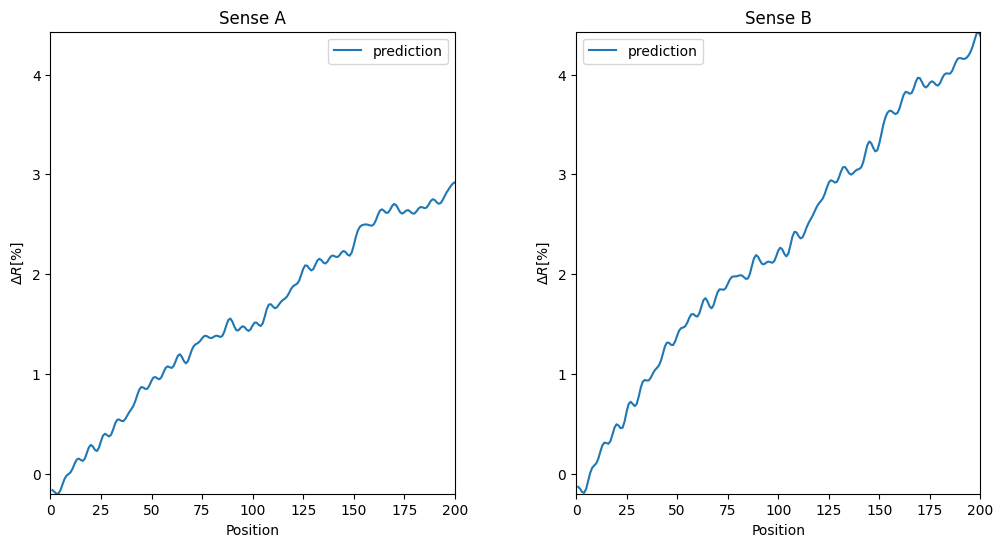

In [11]:
# Define data indices based on your target array structure
# These indices specify where variable ID, position (x-axis), and value are stored
var_index = 2   # Index for variable ID (e.g., Sense A vs Sense B)
x_index = 1     # Index for x-axis (position/cycle)
val_index = 4   # Index for target values

# Optional: map variable IDs to human-readable labels
title_map = {1.0: "Sense A", 2.0: "Sense B"}  # Adjust based on your variables

# Plot predictions for a specific sample (split by variables)
sample_idx = 0
plot_predictions(
    sample_id=sample_idx,
    var_index=var_index,
    x_index=x_index,
    val_index=val_index,
    target_array=target_array,
    output_array=output_array,
    title_map=title_map,
    plot_target=False  # No target available for external inference
)

### 6.3 Cross-Attention Visualization (Optional)

If your model is a transformer (proT), you can visualize the cross-attention weights to understand which input features the model focuses on.

C:\Users\ScipioneFrancesco\Documents\Projects\proT\notebooks\lib.py:801: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


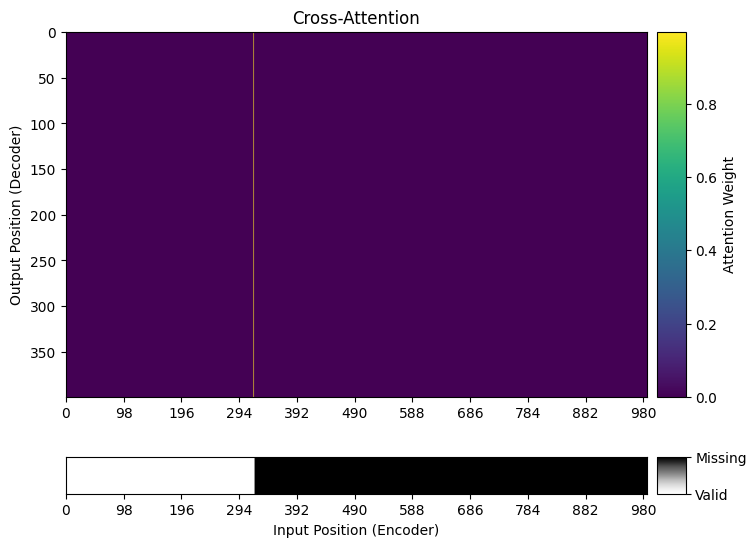

In [12]:
# Plot attention heatmap for the selected sample
# Note: This only works for transformer models (proT), not baseline models

if results.attention_weights is not None and 'cross' in results.attention_weights:
    plot_attention_heatmap(
        sample_id=sample_idx,
        cross_attention=results.attention_weights['cross'],
        input_array=input_array,
        val_index=val_index,
        title="Cross-Attention",
        sum_heads=True  # Sum attention across all heads
    )
else:
    print("Cross-attention weights not available for this model type.")

## 7. Exporting Results

Save your predictions for further analysis or downstream processing.

In [ ]:
# Define output directory
OUTPUT_DIR = ROOT_PATH / "data" / "output" / "predictions"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save predictions as NumPy array
np.save(OUTPUT_DIR / "predictions.npy", output_array)
print(f"Predictions saved to: {OUTPUT_DIR / 'predictions.npy'}")

# Optionally, save as compressed NPZ with all results
np.savez_compressed(
    OUTPUT_DIR / "prediction_results.npz",
    inputs=input_array,
    outputs=output_array,
    targets=target_array
)
print(f"Full results saved to: {OUTPUT_DIR / 'prediction_results.npz'}")

Predictions saved to: C:\Users\ScipioneFrancesco\Documents\Projects\proT\data\output\predictions\predictions.npy
Full results saved to: C:\Users\ScipioneFrancesco\Documents\Projects\proT\data\output\predictions\prediction_results.npz


## 8. Troubleshooting

### Common Issues

**1. Shape Mismatch Error**
- Ensure your input data has the same sequence length (`L`) and number of features (`F_in`) as the training data.
- Check the config file for expected dimensions.

**2. File Not Found Error**
- Verify that the `external_dataset["dataset"]` folder exists inside `DATA_DIR`.
- Check that `X.npy` and `Y.npy` files exist in that folder.

**3. CUDA Out of Memory**
- Reduce batch size in the config before running prediction.
- Or run on CPU by setting `CUDA_VISIBLE_DEVICES=""` environment variable.

**4. NaN Values in Output**
- Check if your input data contains too many missing values.
- Verify the data preprocessing matches what was used during training.

---

## Summary

In this tutorial, you learned how to:

1. ✅ Prepare external data in the correct format
2. ✅ Load a trained proT checkpoint
3. ✅ Run inference using `predict_test_from_ckpt()`
4. ✅ Access and interpret prediction results
5. ✅ Visualize predictions and attention weights
6. ✅ Export results for further analysis

For more advanced usage, refer to the `proT/evaluation/predict.py` module documentation.